# Synthetic data test: Model with multiple sources and moving window scheme

This test is meant to represent a scenario closer to the real data. We'll add multiple sources to the region and run the Euler inversion on a moving window scheme.

In [1]:
from pathlib import Path
import warnings
import numpy as np
from IPython.display import Image
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import xrft
import euler

In [2]:
warnings.filterwarnings("ignore")

## Make a model with multiple sources

Establish the model region, data grid coordinates, magnetization, etc. Then add different sources to the model by superposition.

In [3]:
region = [0, 80e3, 0, 70e3]
spacing = 500
height = 1000
coordinates = vd.grid_coordinates(region, spacing=spacing, extra_coords=height)
inclination, declination = -30, -20
base_level = 1000
noise_level = 50
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

# Dipoles
dipole_coordinates = (30e3, 15e3, -3e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

dipole2_coordinates = (35e3, 20e3, -500)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole2_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(1e11, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

dipole3_coordinates = (60e3, 22e3, -4e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole3_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(5e12, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

dipole4_coordinates = (60e3, 50e3, -1e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole4_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(1e11, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

dipole5_coordinates = (27e3, 50e3, -4e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole5_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(5e12, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Dikes
dike_coordinates_h = (10e3, 30e3, 900)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        dike_coordinates_h[0] - 100e3,
        dike_coordinates_h[0] + 100e3,
        dike_coordinates_h[1] - 100,
        dike_coordinates_h[1] + 100,
        dike_coordinates_h[2] - 7e3,
        dike_coordinates_h[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(20, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

dike_coordinates_v = (20e3, 40e3, 900)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        dike_coordinates_v[0] - 100,
        dike_coordinates_v[0] + 100,
        dike_coordinates_v[1] - 100e3,
        dike_coordinates_v[1] + 100e3,
        dike_coordinates_v[2] - 7e3,
        dike_coordinates_v[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(20, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

def rotate_coordinates(coordinates, azimuth):
    "Rotate a coordinate system by a given azimuth angle"
    angle = np.radians(azimuth)
    rotated = (
        coordinates[0] * np.cos(angle) + coordinates[1] * np.sin(angle),
        -coordinates[0] * np.sin(angle) + coordinates[1] * np.cos(angle),
        coordinates[2],
    )
    return rotated

dike_coordinates_d = (45e3, 25e3, 700)
azimuth = -50
dike_coordinates_rotated = rotate_coordinates(dike_coordinates_d, azimuth)
magnetic_field = hm.prism_magnetic(
    rotate_coordinates(coordinates, azimuth),
    prisms=[
        dike_coordinates_rotated[0] - 100,
        dike_coordinates_rotated[0] + 100,
        dike_coordinates_rotated[1] ,
        dike_coordinates_rotated[1] + 100e3,
        dike_coordinates_rotated[2] - 7e3,
        dike_coordinates_rotated[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(30, inclination, declination + azimuth),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

dike_coordinates_d2 = (20e3, 60e3, 400)
azimuth = -70
dike_coordinates_rotated = rotate_coordinates(dike_coordinates_d2, azimuth)
magnetic_field = hm.prism_magnetic(
    rotate_coordinates(coordinates, azimuth),
    prisms=[
        dike_coordinates_rotated[0] - 100,
        dike_coordinates_rotated[0] + 100,
        dike_coordinates_rotated[1] - 15e3,
        dike_coordinates_rotated[1] + 15e3,
        dike_coordinates_rotated[2] - 7e3,
        dike_coordinates_rotated[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(30, inclination, declination + azimuth),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

Now add a polynomial regional field, some random noise, and a base level.

In [4]:
# Regional
regional_angular_e = 0.02
regional_angular_n = -0.03
magnetic_anomaly += regional_angular_e * coordinates[0] + regional_angular_n * coordinates[1]

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

Number of data: 22701


Now make the data into an `xarray` grid and calculate derivatives using finite-differences (for horizontal) and FFT (for vertical).

In [5]:
# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

data

<xarray.Dataset> Size: 910kB
Dimensions:      (northing: 141, easting: 161)
Coordinates:
    height       (northing, easting) float64 182kB 1e+03 1e+03 ... 1e+03 1e+03
  * easting      (easting) float64 1kB 0.0 500.0 1e+03 ... 7.95e+04 8e+04
  * northing     (northing) float64 1kB 0.0 500.0 1e+03 ... 6.95e+04 7e+04
Data variables:
    field        (northing, easting) float64 182kB 1.008e+03 950.5 ... 399.6
    deriv_east   (northing, easting) float64 182kB -0.1149 0.04187 ... -0.02337
    deriv_north  (northing, easting) float64 182kB -0.1333 0.2865 ... -0.1126
    deriv_up     (northing, easting) float64 182kB -0.2771 0.1876 ... 0.1162

Plot the data and derivatives to make sure it looks OK.

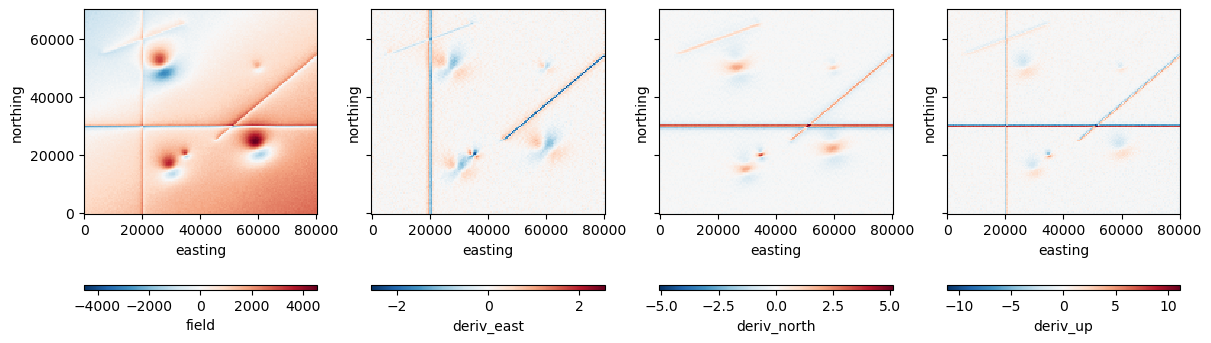

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), layout="constrained", sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

## Run Euler Deconvolution and Inversion

Now run Euler inversion (with weights), Euler deconvolution, and finite-difference Euler deconvolution on a moving window scheme with the same window parameters.

In [7]:
window_size = 10e3
window_step = window_size / 2

Euler deconvolution is run 3 times, once for each SI.

In [8]:
%%time
deconvolutions = {}
for si in [1, 2, 3]:
    deconvolutions[si] = euler.EulerDeconvolutionWindowed(
        structural_index=si,
        window_size=window_size,
        window_step=window_step,
        keep=0.25,
    ).fit_grid(data)

CPU times: user 1.77 s, sys: 4.03 ms, total: 1.78 s
Wall time: 1.78 s


Finite-difference Euler deconvolution is run only once and the SI is estimated.

In [9]:
%%time
fd = euler.EulerDeconvolutionFDWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.3,
).fit_grid(data)

CPU times: user 529 ms, sys: 126 μs, total: 529 ms
Wall time: 527 ms


Euler inversion is run only once and the SI is estimated.

In [10]:
%%time
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.25,
).fit_grid(data)

CPU times: user 193 ms, sys: 115 ms, total: 308 ms
Wall time: 2.86 s


## Make a figure for the paper

Prepare a figure with the synthetic data and the results from Euler deconvolution and inversion.

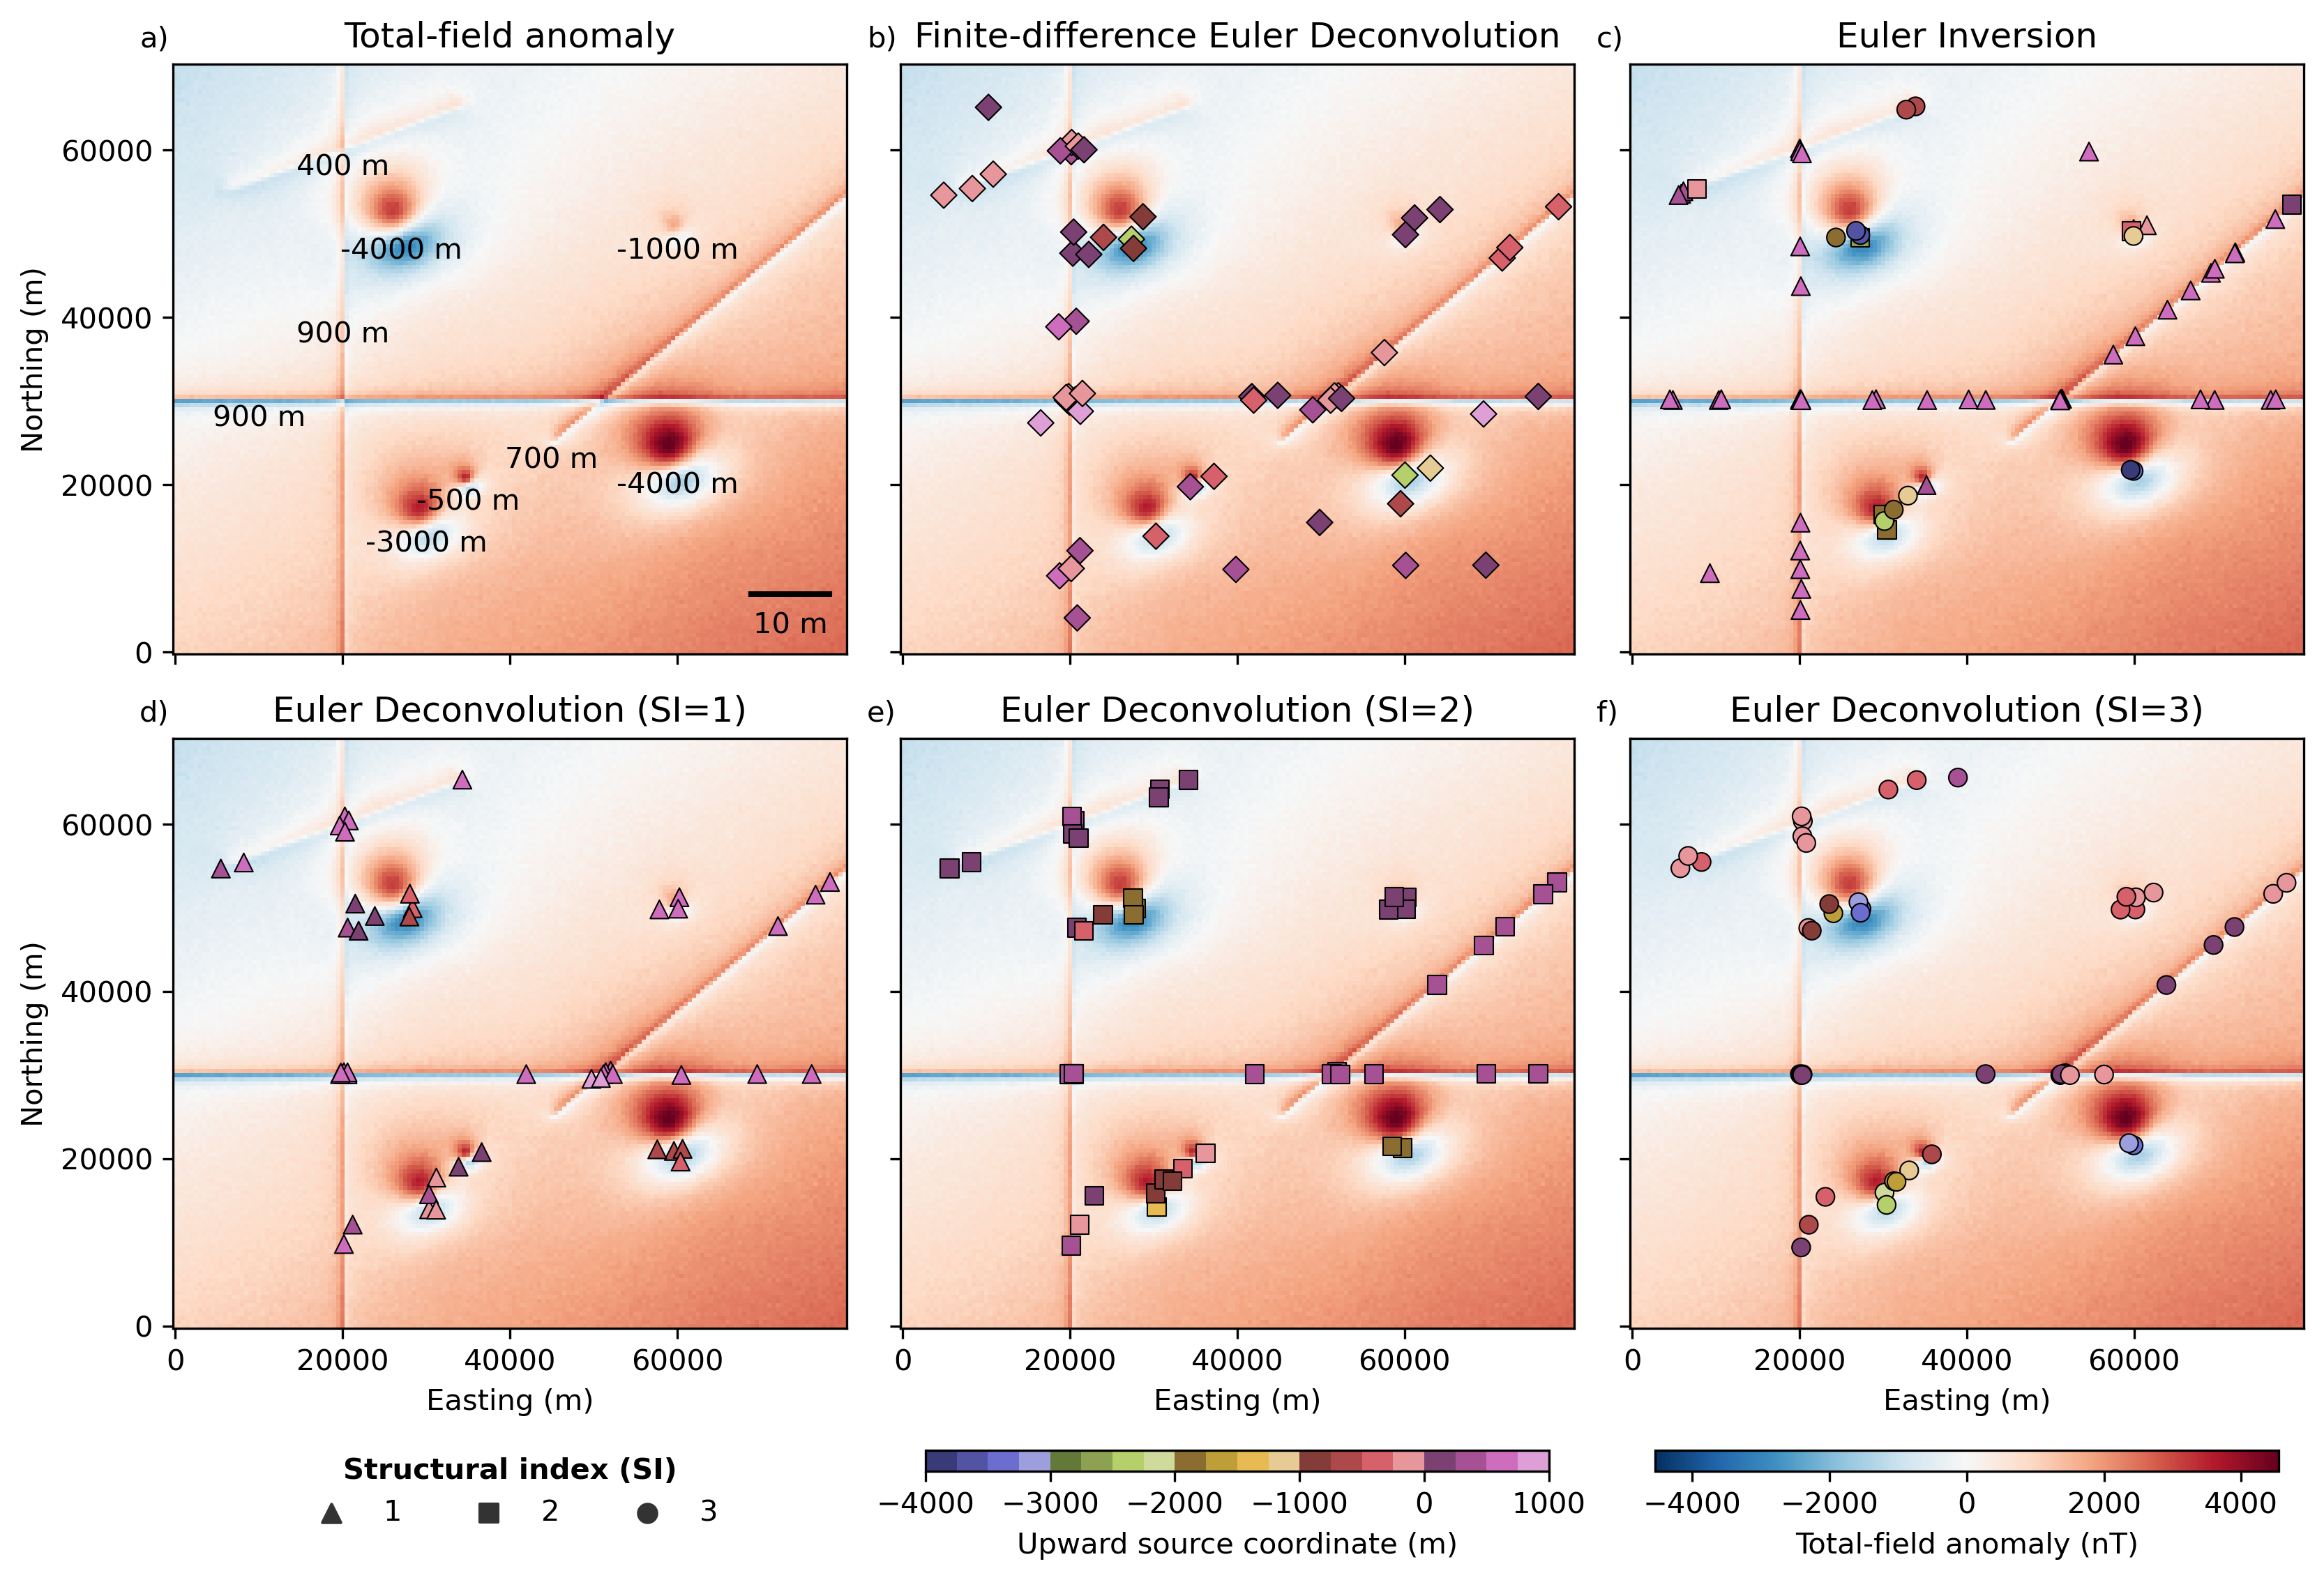

In [11]:
fig, axes = plt.subplots(
    2, 3, figsize=(11, 7.5), layout="constrained", sharey=True, sharex=True
)

markers = ["^", "s", "o"]
vmin, vmax = -4000, 1000
size = 40
linewidth = 0.5
true_sources = [
    dipole_coordinates,
    dipole2_coordinates,
    dipole3_coordinates,
    dipole4_coordinates,
    dipole5_coordinates,
    dike_coordinates_h,
    dike_coordinates_v,
    dike_coordinates_d,
    dike_coordinates_d2,
]

for ax, label in zip(axes.ravel(), "abcdef"):
    ax.set_aspect("equal")    
    ax.text(-0.05, 1.03, f"{label})", transform=ax.transAxes)
    data_plot = data.field.plot.pcolormesh(ax=ax, add_colorbar=False, add_labels=False)

ax = axes[0, 0]
ax.set_title("Total-field anomaly")
for source in true_sources:
    ax.text(
        source[0], source[1] - 3e3, f"{source[2]:.0f} m", horizontalalignment="center"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    ax.scatter(
        *deconvolutions[si].locations_[:2],
        c=deconvolutions[si].locations_[2],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=linewidth,
        cmap="tab20b",
    )

# Finite-difference Euler deconvolution
ax = axes[0, 1]
ax.set_title(f"Finite-difference Euler Deconvolution")
ax.scatter(
    *fd.locations_[:2],
    c=fd.locations_[2],
    s=size,
    marker="D",
    vmin=vmin,
    vmax=vmax,
    edgecolors="black",
    linewidths=linewidth,
    cmap="tab20b",
)

# Euler inversion
labels = {}
ax = axes[0, 2]
ax.set_title("Euler Inversion")
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    depth_plot = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=linewidth,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

fig.colorbar(
    depth_plot,
    ax=axes[1, 1],
    aspect=30,
    pad=0.05,
    shrink=0.9,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)
fig.colorbar(
    data_plot,
    ax=axes[1, 2],
    aspect=30,
    pad=0.05,
    shrink=0.9,
    orientation="horizontal",
    label="Total-field anomaly (nT)",
)
fig.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    ncols=3,
    title="Structural index (SI)",
    loc="lower left",
    bbox_to_anchor=[0.115, 0.015],
    title_fontproperties=dict(weight="bold"),
)

for ax in axes[1, :]:
    ax.set_xticks(np.arange(0, 61e3, 20e3))
for ax in axes[:, 0]:
    ax.set_yticks(np.arange(0, 61e3, 20e3))
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[1, :]:
    ax.set_xlabel("Easting (m)")

# Add a scale bar with the window size
axes[0, 0].add_artist(
    ScaleBar(
        dx=0.001,
        fixed_value=window_size / 1000,
        units="m",
        location="lower right",
        box_alpha=0,
        color="black",
        scale_loc="bottom",
        width_fraction=0.01,
        length_fraction=0.5,
        pad=0.4,        
        scale_formatter=lambda value, unit: f"{value:.0f} {unit}",
    )
)

fig.get_layout_engine().set(w_pad=0, h_pad=0.1, hspace=0, wspace=0)

# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "synthetic-windows.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)